In [1]:
import hiplot as hip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import random
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import os
import glob
import uproot3 as uproot
import scipy

from scipy.optimize import curve_fit
import scipy.stats as stats


import mplhep as hep
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use([hep.styles.ATLAS])

from IPython.core.display import display, HTML
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline

In [2]:
def loadDF(fileName,treeName,cols):
    ''' Function to load a root file '''
    tree=uproot.open(fileName)[treeName]
    df=tree.arrays(cols,outputtype=pd.DataFrame).reset_index(drop=True)
    return df

In [3]:
faccs=[
    "phase1_selected_v2/F2017_1_selected_acc_flat.root",
    "phase1_selected_v2/F2018_1_selected_acc_flat.root",
    "phase1_selected_v2/F2018_8_selected_acc_flat.root"
   ]

faccs2=[]
for f in faccs:
    faccs2.append(loadDF("/d/grid17/ln16/dselector_v3/"+f,"kin",
                         cols=["Mpi0eta","mandelstam_t","Mpi0eta_thrown","mandelstam_t_thrown","weightASBS"]))
faccs2=pd.concat(faccs2)
faccs2=faccs2.reset_index()

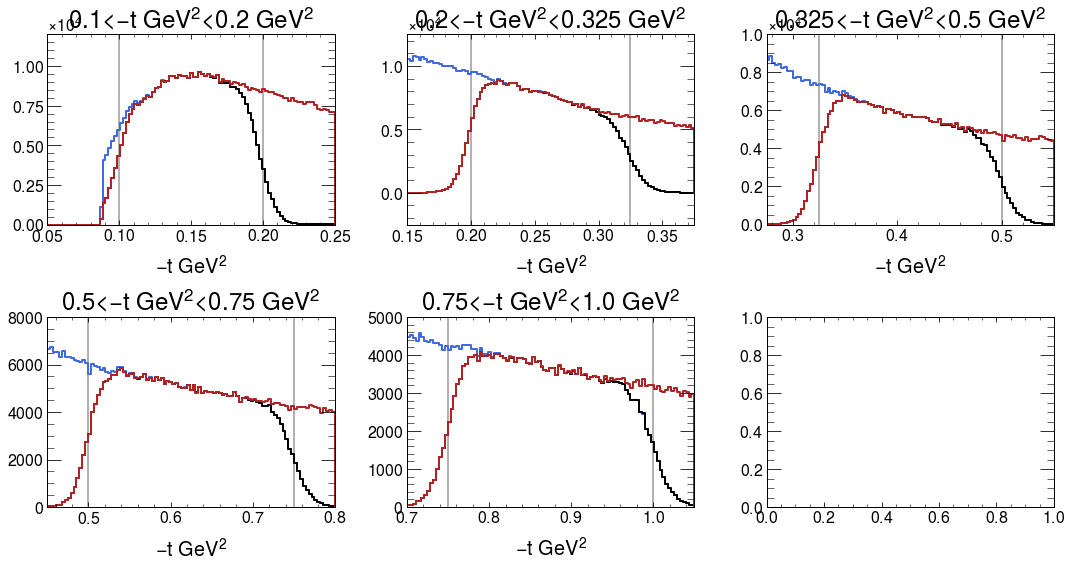

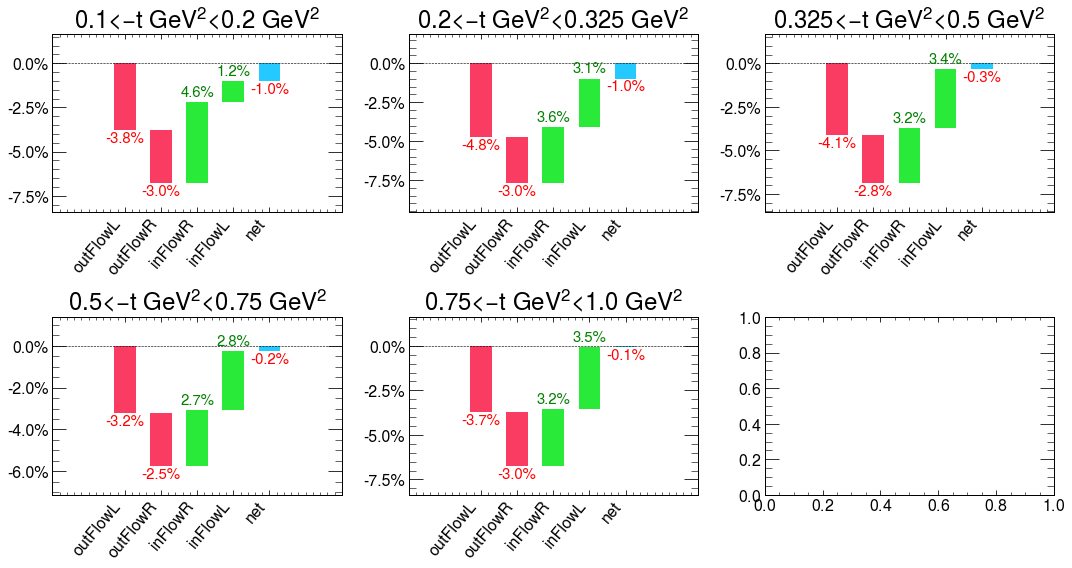

In [14]:
import waterfall_chart

outflowLs=[]
outflowRs=[]
inflowLs=[]
inflowRs=[]

#########################
####### Bin in t ########
#########################
a=faccs2[
    (faccs2.Mpi0eta>1.04)&(faccs2.Mpi0eta<1.56)
        ]
regions=[0.1,0.2,0.325,0.5,0.75,1.0]
rvar="mandelstam_t"
rlabel=r"$-t~GeV^2$"
fig,axes=plt.subplots(2,3,figsize=(15,8))
axes=axes.flatten()
cols=["010020","0200325","0325050","050075","075100"]

#########################
##### Bin in Metapi #####
#########################
# a=faccs2
# regions=[1.04,1.80]
# rvar="Mpi0eta"
# rlabel=r"$M(\eta\pi)$"
# fig,axes=plt.subplots(1,1,figsize=(6,4))
# axes=[axes]
# cols=["104180"]

#########################
## PLOT DISTRIBUTIONS ###
#########################
for ir in range(len(regions)-1):
    test_minr=regions[ir]
    test_maxr=regions[ir+1]
    
    l=a[(a[rvar+"_thrown"]<test_maxr)]
    m=a[(a[rvar+"_thrown"]>test_minr)&(a[rvar+"_thrown"]<test_maxr)]
    u=a[(a[rvar+"_thrown"]>test_minr)]
    
    
    outflowL=m[(m[rvar]<test_minr)].weightASBS.sum()
    outflowR=m[(m[rvar]>test_maxr)].weightASBS.sum()
    staticflow=m[(m[rvar]>test_minr)&((m[rvar]<test_maxr))].weightASBS.sum()
    inflowL=l[(l[rvar]>test_minr)&((l[rvar]<test_maxr))].weightASBS.sum()-staticflow
    inflowR=u[(u[rvar]>test_minr)&((u[rvar]<test_maxr))].weightASBS.sum()-staticflow
        
    outflowLs.append(-100*outflowL/staticflow)
    outflowRs.append(-100*outflowR/staticflow)
    inflowLs.append(100*inflowL/staticflow)
    inflowRs.append(100*inflowR/staticflow)

    xmin=test_minr-0.05
    xmax=test_maxr+0.05
    axes[ir].axvline(test_minr,c='gray',alpha=0.6)
    axes[ir].axvline(test_maxr,c='gray',alpha=0.6)
    for d,c in zip([l,m,u],["royalblue","black","firebrick"]):
        hep.histplot(np.histogram(d[rvar],weights=d.weightASBS,bins=np.linspace(xmin,xmax,100)),ax=axes[ir],c=c)  
    axes[ir].set_xlim(xmin,xmax) 
    axes[ir].set_xlabel(rlabel)
    axes[ir].set_title(f"{regions[ir]}<"+rlabel+f"<{regions[ir+1]} $GeV^2$",size=24)

# fig.subplots_adjust(wspace=0)
plt.tight_layout()
plt.savefig("/d/grid17/ln16/dselector_v3/study_binMigration/migration_hists.png")


#########################
####### Bin in t ########
#########################
fig2,axes2=plt.subplots(2,3,figsize=(15,8))
axes2=axes2.flatten()

#########################
##### Bin in Metapi #####
#########################
# fig2,axes2=plt.subplots(1,1,figsize=(6,5))
# axes2=[axes2]

#########################
####### PLOT FLOWS ######
#########################
flows=pd.DataFrame(np.vstack([outflowLs,outflowRs,inflowRs,inflowLs]), 
             index=["outFlowL","outFlowR","inFlowR","inFlowL"],
             columns=cols,
            )

for ir, col in enumerate(flows.columns):
    waterfall_chart.plot(flows.index,flows[col],ax=axes2[ir],rotation_value=50,fontsize=15,formatting="{:,.1f}%")
    axes2[ir].set_title(f"{regions[ir]}<"+rlabel+f"<{regions[ir+1]} $GeV^2$",size=24)
plt.tight_layout()
plt.savefig("/d/grid17/ln16/dselector_v3/study_binMigration/migration_waterfall.png")